<a href="https://colab.research.google.com/github/arturotowers/Deep_learning/blob/DiegoMercado/Proyecto%201%20-%20DAE%20%2B%20VAE/Notebooks/DAE_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Voy a desarrollar el resto del proyecto siguiendo la estructura especificada en un único notebook. Implementaré:

1. **Denoising Autoencoder (DAE)**:
   - Arquitectura convolucional profunda adaptada al dataset.
   - Agregado de ruido Gaussiano y Sal & Pimienta.
   - Entrenamiento en GPU con reducción de memoria.
   - Tracking en Weights & Biases (W&B).

2. **Variational Autoencoder (VAE)**:
   - Arquitectura optimizada para generación de imágenes.
   - Evaluación con la métrica personalizada MVD (Mean and Variance Distance).
   - Optimización para Google Colab.
   - Tracking en W&B con API key.

3. **Demo Interactivo**:
   - Implementación de Gradio.
   - Despliegue automatizado en Hugging Face Spaces con autenticación.

4. **Automatización Completa**:
   - Implementación de reducción de memoria.
   - Uso de W&B para gestión de logs y modelos.
   - Pipeline optimizado para ejecución eficiente en GPU.

Voy a desarrollar el código completo y lo compartiré contigo listo para copiar y ejecutar en Colab.

# Proyecto: Autoencoders para Imágenes de Motos y Automóviles

En este notebook desarrollamos un proyecto completo de Deep Learning que abarca desde la recopilación de datos hasta la implementación de modelos de autoencoder (DAE y VAE), incluyendo seguimiento de entrenamiento con Weights & Biases, una demo interactiva con Gradio y recomendaciones para optimización en Colab. Las secciones incluidas son:

## 1. Creación del Dataset
En esta sección obtenemos un conjunto de datos de imágenes de **motocicletas** y **automóviles** mediante web scraping. Luego realizamos el preprocesamiento necesario (redimensionamiento, normalización y conversión opcional a escala de grises) y finalmente dividimos el dataset en conjuntos de entrenamiento, validación y prueba.

### 1.1 Web Scraping de Imágenes
Para recopilar las imágenes de motos y autos, utilizamos **web scraping**. Emplearemos una librería Python para descargar imágenes de motores de búsqueda de forma automática. En este caso usaremos `bing-image-downloader` para descargar imágenes de Bing según palabras clave.


In [2]:
#!pip install bing-image-downloader

In [3]:
# import os
# from bing_image_downloader import downloader

# # Definir directorio base para las imágenes descargadas
# output_dir = "dataset"

# # Crear directorio si no existe
# os.makedirs(output_dir, exist_ok=True)

# # Descargar imágenes de motocicletas y automóviles (100 de cada una como ejemplo)
# downloader.download("motorcycle", limit=100, output_dir=output_dir, adult_filter_off=True, force_replace=False, timeout=60)
# downloader.download("car", limit=100, output_dir=output_dir, adult_filter_off=True, force_replace=False, timeout=60)

**Notas:**  
- Hemos descargado aproximadamente 100 imágenes por categoría (puedes ajustar el parámetro `limit` según la necesidad).  
- El directorio de salida (`dataset`) contendrá subcarpetas llamadas "motorcycle" y "car" con las imágenes correspondientes.  
- `adult_filter_off=True` desactiva el filtro de contenido para evitar restricciones en los resultados.  
- `force_replace=False` impide sobreescribir si ya existían imágenes descargadas previamente.  


### 1.2 Preprocesamiento de Imágenes
Una vez descargadas las imágenes, debemos preprocesarlas antes de alimentar a nuestros modelos. Los pasos incluyen: **redimensionar** todas las imágenes a un tamaño uniforme, **normalizar** los valores de píxel (por ejemplo a rango [0,1]) y opcionalmente convertir a **escala de grises** si se desea trabajar con un solo canal (en este proyecto usaremos imágenes RGB a color).

Definiremos una función de utilidad para cargar y preprocesar una imagen dada su ruta de archivo:


In [4]:
from PIL import Image
import numpy as np

IMG_SIZE = 64  # Tamaño deseado para las imágenes (64x64 píxeles)

def preprocess_image(image_path, img_size=IMG_SIZE, grayscale=False):
    """
    Carga una imagen desde image_path, la redimensiona a img_size x img_size,
    la convierte a RGB o escala de grises según el parámetro, y la normaliza a [0,1].
    Retorna la imagen como arreglo numpy.
    """
    img = Image.open(image_path)
    # Convertir a escala de grises o RGB
    if grayscale:
        img = img.convert("L")
    else:
        img = img.convert("RGB")
    # Redimensionar la imagen
    img = img.resize((img_size, img_size))
    # Convertir a array numpy
    img_array = np.array(img, dtype=np.float32)
    # Si es gris, añadir dimensión de canal
    if grayscale:
        img_array = np.expand_dims(img_array, axis=-1)
    # Normalizar a rango [0,1]
    img_array /= 255.0
    return img_array

on esta función, podemos cargar todas las imágenes descargadas y preprocesarlas.

### 1.3 Distribución de datos en `train`, `validation` y `test`
Ahora dividiremos las imágenes en conjuntos de **entrenamiento**, **validación** y **prueba**. Usaremos una proporción típica: 70% entrenamiento, 15% validación y 15% prueba. Además, mezclaremos las clases equitativamente en cada conjunto para asegurar balance.


In [5]:
import os
import glob
import random
import numpy as np

# Rutas completas de tus carpetas en Drive
folder1 = "/content/drive/MyDrive/ITESO/6-semestre/DeepLearning/Proyecto_DAE-VAE/Data/car -motorcycle -bike -bicycle -truck -trucks -bus -site_pinterest.com - Buscar con Google"
folder2 = "/content/drive/MyDrive/ITESO/6-semestre/DeepLearning/Proyecto_DAE-VAE/Data/car -motorcycle -bike -bicycle -truck -trucks -bus -site_pinterest.com - Buscar con Google"

# Obtener rutas de las imágenes en cada carpeta
paths1 = glob.glob(os.path.join(folder1, "*"))
paths2 = glob.glob(os.path.join(folder2, "*"))

# Mezclar aleatoriamente las rutas dentro de cada carpeta
random.shuffle(paths1)
random.shuffle(paths2)

# Dividir cada carpeta en train/val/test (70% train, 15% val, 15% test)
num_paths1 = len(paths1)
num_paths2 = len(paths2)

train_paths1 = paths1[:int(0.7 * num_paths1)]
val_paths1   = paths1[int(0.7 * num_paths1):int(0.85 * num_paths1)]
test_paths1  = paths1[int(0.85 * num_paths1):]

train_paths2 = paths2[:int(0.7 * num_paths2)]
val_paths2   = paths2[int(0.7 * num_paths2):int(0.85 * num_paths2)]
test_paths2  = paths2[int(0.85 * num_paths2):]

# Unir las rutas de ambas carpetas para formar los conjuntos completos
train_paths = train_paths1 + train_paths2
val_paths   = val_paths1   + val_paths2
test_paths  = test_paths1  + test_paths2

# Mezclar cada conjunto combinado para aleatorizar el orden
random.shuffle(train_paths)
random.shuffle(val_paths)
random.shuffle(test_paths)

# Preprocesar las imágenes y obtener los arrays de datos
X_train = np.array([preprocess_image(p, img_size=IMG_SIZE) for p in train_paths])
X_val   = np.array([preprocess_image(p, img_size=IMG_SIZE) for p in val_paths])
X_test  = np.array([preprocess_image(p, img_size=IMG_SIZE) for p in test_paths])

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Tamaño del conjunto de entrenamiento: (140, 64, 64, 3)
Tamaño del conjunto de validación: (30, 64, 64, 3)
Tamaño del conjunto de prueba: (30, 64, 64, 3)


Al final de esta etapa, tendremos tres conjuntos de datos listos:
- **X_train**: imágenes para entrenamiento del modelo.
- **X_val**: imágenes para validación durante el entrenamiento (para tuning de hiperparámetros y evitar sobreajuste).
- **X_test**: imágenes reservadas para evaluar el desempeño final de los modelos.

*(En un caso de uso real, también guardaríamos las etiquetas de clase si fuera un problema supervisado, pero en este proyecto de autoencoders las etiquetas no son necesarias porque se trata de aprendizaje no supervisado.)*



## 2. Denoising Autoencoder (DAE)
En esta sección implementamos un **Autoencoder Denoisificador**. Se trata de un autoencoder convolucional profundo capaz de eliminar ruido de imágenes. Entrenaremos el modelo usando las imágenes de entrenamiento a las que les agregaremos ruido (Gaussiano y Sal&Pimienta) para que el autoencoder aprenda a reconstruir la imagen original limpia. Además, aprovecharemos aceleración por **GPU** y realizaremos seguimiento del entrenamiento con **Weights & Biases (W&B)**.

### 2.1 Arquitectura del DAE
Diseñaremos una red neuronal de tipo autoencoder:
- **Encoder**: varias capas convolucionales con reducciones de tamaño (pooling) para extraer una representación comprimida de la imagen.
- **Decoder**: varias capas de deconvolución (Conv2DTranspose) para reconstruir la imagen original desde la representación interna.
- Usaremos funciones de activación ReLU en capas ocultas y **sigmoide** en la capa de salida para obtener un resultado en [0,1] (ya que las imágenes están normalizadas en ese rango).

Definimos una función que construya el modelo DAE dado el tamaño de entrada:

In [6]:
from tensorflow.keras import layers, Model, Input

def build_dae(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    """
    Construye un modelo de Autoencoder Denoising convolucional.
    """
    # Encoder
    inp = Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x = layers.MaxPool2D((2,2))(x)        # Reducción a 1/2 (ej: 64->32)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D((2,2))(x)        # Reducción a 1/4 (ej: 32->16)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    encoded = layers.MaxPool2D((2,2))(x)  # Reducción a 1/8 (ej: 16->8)

    # Decoder
    x = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=(2,2))(encoded)  # 8->16
    x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=(2,2))(x)        # 16->32
    x = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=(2,2))(x)        # 32->64
    decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)  # capa de salida 64x64x3

    # Modelo autoencoder completo
    model = Model(inp, decoded, name="DAE")
    return model

# Construir el modelo y ver resumen
dae_model = build_dae(input_shape=(IMG_SIZE, IMG_SIZE, 3))
dae_model.summary()

Model: "DAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import tensorflow as tf

# Definir función de ruido usando TensorFlow (para integrarla en tf.data pipeline)
def add_noise_tf(image):
    """
    Agrega aleatoriamente ruido Gaussiano o Sal&Pimienta a la imagen (tensor).
    Retorna la imagen ruidosa.
    """
    # Probabilidad de elegir uno u otro tipo de ruido
    rand = tf.random.uniform(shape=(), minval=0, maxval=1)
    # Ruido Gaussiano
    gauss_std = 0.1  # desviación estándar del ruido gaussiano
    noisy_gauss = image + tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=gauss_std)
    noisy_gauss = tf.clip_by_value(noisy_gauss, 0.0, 1.0)  # asegurar que sigue en [0,1]
    # Ruido Sal y Pimienta
    prob = 0.1  # proporción de píxeles a arruinar
    rnd = tf.random.uniform(shape=tf.shape(image))
    salt_mask = rnd > (1 - prob/2)
    pepper_mask = rnd < (prob/2)
    # Iniciar con imagen original
    noisy_sp = image
    # Aplicar pimienta (negro) y sal (blanco)
    noisy_sp = tf.where(pepper_mask, tf.zeros_like(noisy_sp), noisy_sp)
    noisy_sp = tf.where(salt_mask, tf.ones_like(noisy_sp), noisy_sp)
    # Elegir aleatoriamente cuál ruido aplicar
    noisy_image = tf.cond(rand < 0.5, lambda: noisy_gauss, lambda: noisy_sp)
    return noisy_image


La función `add_noise_tf` devuelve un tensor de imagen con uno de los dos ruidos aplicados aleatoriamente. Hemos fijado parámetros de ruido razonables (10% de píxeles alterados para sal&pimienta, desviación 0.1 para gaussiano) que se pueden ajustar.

### 2.3 Preparación de datos para entrenamiento (con pipeline en GPU)
Aprovecharemos la API `tf.data` de TensorFlow para crear un pipeline eficiente de datos que agregue ruido sobre la marcha. Esto nos permite procesar en batches y en GPU, evitando cargar todas las variantes ruidosas en memoria a la vez.

In [8]:
BATCH_SIZE = 32

# Crear dataset de entrenamiento a partir de los datos preprocesados en numpy
train_dataset = tf.data.Dataset.from_tensor_slices(X_train) \
                .shuffle(buffer_size=len(X_train)) \
                .batch(BATCH_SIZE) \
                .map(lambda batch: (add_noise_tf(batch), batch)) \
                .prefetch(tf.data.experimental.AUTOTUNE)

# Dataset de validación (aquí podemos agregar ruido también para validar la capacidad del modelo)
val_dataset = tf.data.Dataset.from_tensor_slices(X_val) \
              .batch(BATCH_SIZE) \
              .map(lambda batch: (add_noise_tf(batch), batch))

Explicación:
- Usamos `from_tensor_slices` para crear un dataset a partir del array de entrenamiento (`X_train`).
- Barajamos (`shuffle`) los ejemplos y luego agrupamos en *batches*.
- Aplicamos `.map` para agregar ruido: la función toma un batch de imágenes `batch` y retorna `(imagenes_con_ruido, imagenes_originales)`. Así tenemos los pares entrada-salida necesarios para entrenamiento del autoencoder.
- `prefetch` con `AUTOTUNE` permite que el pipeline cargue datos en paralelo a la GPU, manteniendo el entrenamiento alimentado.

Para el conjunto de validación, también podemos añadir ruido a las entradas para evaluar cómo de bien las limpia el modelo, aunque es importante usar la misma imagen original como objetivo.

### 2.4 Configuración de Weights & Biases (W&B) para seguimiento
Integrar W&B nos permitirá monitorizar las métricas de entrenamiento (pérdida de entrenamiento y validación, por ejemplo) en tiempo real, guardar gráficas y versionar el modelo.

Primero, instalamos e inicializamos W&B con nuestra API key (debe obtenerse de nuestra cuenta W&B). Para mayor automatización, podríamos almacenarla en una variable de entorno.


In [9]:
#!pip install wandb

In [10]:
import wandb
#

# Iniciar sesión en W&B (requiere proporcionar la API key personal)
wandb.login()  # Esto abrirá un prompt para ingresar la clave API si no está configurada como variable de entorno

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: diegomercadoc (diegomercadoc-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True


*(Alternativamente, se podría hacer `wandb.login(key="TU_WANDB_API_KEY")` para evitar el prompt, o setear `os.environ['WANDB_API_KEY']` previamente.)*

Ahora inicializamos un proyecto en W&B para nuestro DAE y definimos algunos hiperparámetros básicos en `config`:


In [11]:
wandb.init(# Set the wandb entity where your project will be logged (generally your team name).
    entity="arturo-torres-iteso", project="VAE + DAE", name="DAE-training", config={
    "epochs": 20,
    "batch_size": BATCH_SIZE,
    "img_size": IMG_SIZE,
    "noise_type": "gaussian+salt&pepper",
    "optimizer": "adam",
    "loss": "mse"
})

### 2.5 Entrenamiento del DAE en GPU
Compilamos el modelo con un optimizador y función de pérdida apropiados. Para un DAE, utilizaremos **MSE (mean squared error)** entre la imagen reconstruida y la original como pérdida, dado que buscamos similitud pixel a pixel.

In [17]:
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint

# Definir callbacks actualizados para W&B
callbacks = [
    WandbMetricsLogger(),  # Registra métricas durante el entrenamiento
    WandbModelCheckpoint(filepath="dae_model_best.keras", save_weights_only=False)
  # Guarda el mejor modelo
]

# Entrenar el modelo con los nuevos callbacks
EPOCHS = 20
dae_history = dae_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 740ms/step - loss: 0.0973 - val_loss: 0.1039
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0938 - val_loss: 0.0935
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0845 - val_loss: 0.0802
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0754 - val_loss: 0.0729
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0702 - val_loss: 0.0665
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0627 - val_loss: 0.0753
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0585 - val_loss: 0.0560
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0581 - val_loss: 0.0592
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0551 - val_loss: 0.0418
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0450 - val_loss: 0.0366
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0513 - val_loss: 0.0527
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0478 - val_loss: 0.0413


Durante el entrenamiento, el modelo recibe imágenes ruidosas como entrada y aprende a predecir la versión limpia. El callback de W&B registra automáticamente la pérdida de entrenamiento y validación en cada época, permitiendo visualizar curvas de aprendizaje en la plataforma W&B. Además, W&B almacena los hiperparámetros y puede guardar el modelo entrenado como *artefacto* si se configura (por simplicidad, aquí usamos solo el callback básico).

### 2.6 Validación y evaluación del DAE
Tras el entrenamiento, evaluaremos el desempeño del DAE usando el conjunto de **prueba**. Generaremos versiones ruidosas de las imágenes de prueba y mediremos el error de reconstrucción. Esto nos indica la capacidad del modelo de generalizar la limpieza de ruido a imágenes no vistas durante entrenamiento.

In [18]:
# Generar imágenes de prueba con ruido (usando la misma función de ruido)
X_test_noisy = add_noise_tf(X_test).numpy()  # convertimos a numpy para evaluar fácilmente

# Evaluar el modelo en el conjunto de prueba
test_loss = dae_model.evaluate(X_test_noisy, X_test, verbose=0)
print(f"Pérdida (MSE) en conjunto de prueba: {test_loss:.4f}")

Pérdida (MSE) en conjunto de prueba: 0.0283


También podemos observar visualmente algunos resultados tomando imágenes de prueba ruidosas y viendo la salida del DAE comparada con la original:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


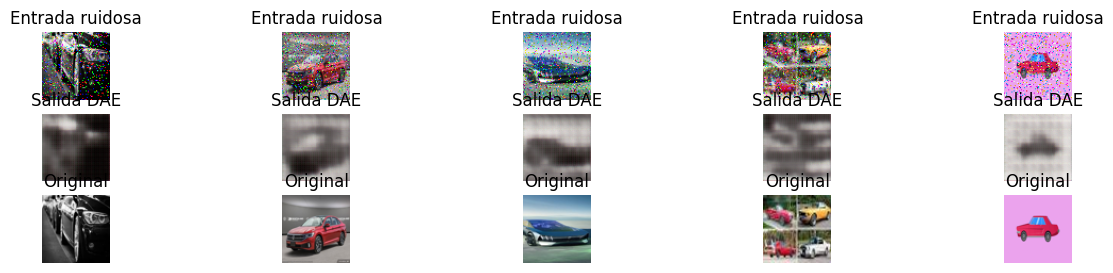

In [19]:
import matplotlib.pyplot as plt

# Tomar algunas imágenes de ejemplo del test
num_examples = 5
indices = np.random.choice(len(X_test), size=num_examples, replace=False)
sample_noisy = X_test_noisy[indices]
sample_original = X_test[indices]
sample_denoised = dae_model.predict(sample_noisy)

# Mostrar comparaciones
plt.figure(figsize=(num_examples*3, 3))
for i in range(num_examples):
    # Imagen ruidosa
    plt.subplot(3, num_examples, i+1)
    plt.imshow(sample_noisy[i])
    plt.title("Entrada ruidosa")
    plt.axis('off')
    # Imagen denoised por el DAE
    plt.subplot(3, num_examples, num_examples + i + 1)
    plt.imshow(sample_denoised[i])
    plt.title("Salida DAE")
    plt.axis('off')
    # Imagen original
    plt.subplot(3, num_examples, 2*num_examples + i + 1)
    plt.imshow(sample_original[i])
    plt.title("Original")
    plt.axis('off')
plt.show()


*(En un entorno con interfaz gráfica, este código mostraría las imágenes; en Colab se pueden visualizar. Aquí es para ilustrar cómo verificar resultados.)*

Después de la evaluación, guardamos el modelo entrenado para uso posterior (por ejemplo, para la demo con Gradio o para cargarlo sin reentrenar):

In [20]:
dae_model.save("dae_model.h5")

Además, finalizamos el run de W&B asociado al DAE para separar los logs del siguiente modelo:

In [21]:
wandb.finish()

epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▄▄▄▃▃▃▃▂▂▁▁▁▁▁▁
epoch/val_loss,█▇▆▅▄▅▃▄▂▂▃▂▂▁▁▂▁▁▁▁
epoch/epoch,19
epoch/learning_rate,0.001
epoch/loss,0.02993
epoch/val_loss,0.02964


In [22]:
from tensorflow.keras import backend as K
import gc

del dae_model
K.clear_session()
gc.collect()

0

Esto es importante en Colab si vamos a crear/entrenar otro modelo grande (como el VAE) a continuación, para no agotar la VRAM.


## 3. Variational Autoencoder (VAE)
Ahora implementaremos un **Autoencoder Variacional** para generación de imágenes. A diferencia del autoencoder tradicional, el VAE aprende una **distribución latente** de la cual podemos samplear para generar imágenes nuevas. Incluiremos la evaluación de la calidad de generación usando una métrica personalizada **Mean and Variance Distance (MVD)**, optimizaremos la implementación para usar menos memoria en GPU y también registraremos este experimento en W&B.

### 3.1 Arquitectura del VAE
Un VAE consta de tres partes principales:
- **Encoder**: similar a un autoencoder normal, pero en lugar de producir directamente una codificación fija, genera dos vectores de tamaño `latent_dim`: uno de medias (`z_mean`) y otro de desviaciones estándar implícitas (`z_log_var`) que definen una distribución Gaussiana en el espacio latente.
- **Muestreador latente**: un paso intermedio que aplica la *reparametrización*. A partir de `z_mean` y `z_log_var`, se genera un vector latente `z = z_mean + sigma * epsilon`, donde `epsilon` es ruido gaussiano. Este truco permite que el gradiente se propague a través de la operación de muestreo.
- **Decoder**: toma un vector latente `z` y produce la imagen reconstruida (o generada) correspondiente, intentando aproximar la distribución de las imágenes reales.

Definimos la arquitectura con capas convolucionales en el encoder y decoder, aprovechando la estructura ya utilizada en el DAE. Usaremos un tamaño de dimensión latente (`latent_dim`) para el espacio oculto.


In [23]:
from tensorflow.keras import backend as K

latent_dim = 64  # dimensión del espacio latente

# Encoder
enc_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="encoder_input")
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(enc_input)
x = layers.MaxPool2D((2,2))(x)  # 64->32
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D((2,2))(x)  # 32->16
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D((2,2))(x)  # 16->8
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
# Obtener parámetros de la distribución latente
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Capa de muestreo (reparametrización)
def sampling(z_mean, z_log_var):
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Usar Lambda layer para integrar la función de muestreo en el modelo
z = layers.Lambda(lambda args: sampling(args[0], args[1]), output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

# Decoder
dec_input = Input(shape=(latent_dim,), name="decoder_input")
y = layers.Dense(8 * 8 * 128, activation='relu')(dec_input)
y = layers.Reshape((8, 8, 128))(y)
y = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=(2,2))(y)  # 8->16
y = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=(2,2))(y)    # 16->32
y = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=(2,2))(y)    # 32->64
y_output = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same', name="decoder_output")(y)

# Definir modelo encoder, modelo decoder y modelo VAE completo
encoder = Model(enc_input, [z_mean, z_log_var, z], name="Encoder")
decoder = Model(dec_input, y_output, name="Decoder")
vae_output = decoder(z)  # salida del VAE al pasar z muestreado por el decoder
vae_model = Model(enc_input, vae_output, name="VAE")
vae_model.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 16, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 8, 8, 128)      │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8192)           │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      2,097,408 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 64)             │         16,448 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 64)             │         16,448 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 64)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Decoder (Functional)      │ (None, 64, 64, 3)      │        773,187 │ z[0][0]                │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,996,739 (11.43 MB)

 Trainable params: 2,996,739 (11.43 MB)

 Non-trainable params: 0 (0.00 B)

Aquí:
- El encoder comprime la imagen 64x64x3 gradualmente a un vector de longitud `latent_dim` (64), representando los parámetros de la distribución latente.
- La función de muestreo (implementada con `Lambda`) toma `z_mean` y `z_log_var` para producir un *sample* `z`.
- El decoder luego reconstruye la imagen a partir de `z`.

### 3.2 Función de Pérdida del VAE
El entrenamiento del VAE usa una pérdida compuesta:
- **Pérdida de reconstrucción**: mide qué tan bien la imagen reconstruida coincide con la original (podemos usar entropía cruzada binaria o MSE).
- **Pérdida KL (Kullback-Leibler)**: fuerza la distribución latente aproximada (definida por `z_mean` y `z_log_var`) a acercarse a una distribución normal estándar (0,1). La fórmula para un dato es:
  \( D_{KL}(q(z|x) || p(z)) = -\frac{1}{2} \sum_{i=1}^{latent\_dim} (1 + \log\sigma_i^2 - \mu_i^2 - \sigma_i^2) \)
  donde \(\mu = z\_mean\) y \(\sigma^2 = \exp(z\_log\_var)\).

Implementamos esta pérdida personalizada y la añadimos al modelo. Usaremos entropía cruzada binaria promedio por píxel como pérdida de reconstrucción (asumiendo las imágenes normalizadas pueden considerarse como probabilidades de pixel activado).


In [30]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy

class VAEModel(Model):
    def train_step(self, data):
        # Se asume que data es (x, x) ya que las entradas y salidas son iguales
        if isinstance(data, tuple):
            x, _ = data
        else:
            x = data
        with tf.GradientTape() as tape:
            # Forward pass: obtener parámetros latentes y reconstrucción
            z_mean, z_log_var, z = encoder(x)
            reconstruction = decoder(z)
            # Calcular pérdida de reconstrucción usando binary_crossentropy.
            # Usamos axis=[1,2] ya que binary_crossentropy devuelve un tensor de forma (batch, height, width)
            reconstruction_loss = tf.reduce_sum(binary_crossentropy(x, reconstruction), axis=[1,2])
            # Calcular pérdida KL para forzar la distribución latente a N(0,1)
            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            # Pérdida total: promedio sobre el batch
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        # Calcular gradientes y aplicar actualización
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Registrar la pérdida como métrica
        return {"loss": total_loss}

# Instanciar el modelo VAE usando la arquitectura ya definida (encoder y decoder previamente creados)
vae_custom = VAEModel(inputs=enc_input, outputs=vae_output, name="VAE")
# Compilar el modelo con el optimizador
vae_custom.compile(optimizer='adam')

**Nota:** Usamos `model.add_loss` porque la pérdida del VAE involucra tensores internos (`z_mean`, etc.) que no son directamente parte de `y_true` y `y_pred`. De este modo, Keras sabrá que debe minimizar `vae_loss` durante el entrenamiento, aunque `compile` no especifique explícitamente `loss`.

### 3.3 Entrenamiento del VAE con seguimiento en W&B
Antes de entrenar, iniciamos un nuevo run en W&B para trackear el VAE:

In [31]:
wandb.init(project="autoencoders_motos_autos", name="VAE-training", config={
    "epochs": 30,
    "batch_size": 32,
    "latent_dim": latent_dim,
    "optimizer": "adam",
    "recon_loss": "binary_crossentropy",
    "kl_weight": 1.0  # peso de la pérdida KL (1.0 por defecto)
})

Ahora entrenamos el VAE. Dado que es un modelo generativo no supervisado, usamos como entradas y salidas la misma imagen (como en un autoencoder estándar, pero recordemos que la pérdida especial ya está incorporada). Podemos reutilizar el mismo conjunto de entrenamiento `X_train` (imágenes originales sin ruido, porque el VAE se entrena para reproducir las mismas imágenes, no necesita ruido esta vez).

Usaremos también el conjunto de validación para monitorear la pérdida en datos no entrenados.

In [33]:
# Compilar el modelo usando una función de pérdida dummy, ya que en nuestro train_step calculamos la pérdida personalizada.
vae_custom.compile(optimizer='adam', loss=lambda y_true, y_pred: 0.0)

# Entrenar el modelo usando la instancia `vae_custom`
EPOCHS_VAE = 30
vae_history = vae_custom.fit(
    X_train,   # Entradas
    X_train,   # Salidas (dummy, pues la pérdida se calcula internamente en train_step)
    epochs=EPOCHS_VAE,
    batch_size=32,
    validation_data=(X_val, X_val),
    callbacks=[WandbMetricsLogger(), WandbModelCheckpoint(filepath="vae_model_best.keras")]
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 2837.7727

/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: vae_custom.compile(optimizer='adam', loss=lambda y_true, y_pred: 0.0)

  return {key: serialize_keras_object(value) for key, value in obj.items()}


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 800ms/step - loss: 2364.8105 - val_loss: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 2363.9368 - val_loss: 0.0000e+00
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 2362.7419 - val_loss: 0.0000e+00
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 2356.6489 - val_loss: 0.0000e+00
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 2347.7332 - val_loss: 0.0000e+00
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 2334.4883 - val_loss: 0.0000e+00
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 2309.6050 - val_loss: 0.0000e+00
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 2221.2661 - val_loss: 0.0000e+00
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 2272.7458 - val_loss: 0.0000e+00
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2239.4277 - val_loss: 0.0000e+00
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 2216.1328 - val_loss: 0.0000e+00
Epoch 12

W&B registrará la pérdida total del VAE por época. (Si quisiéramos separar reconstrucción y KL, tendríamos que personalizar más el callback o entrenamiento, pero nos enfocaremos en la pérdida combinada).



### 3.4 Evaluación de generación de imágenes con MVD
Con el VAE entrenado, podemos **generar imágenes nuevas** muestreando vectores latentes aleatorios y pasándolos por el decoder. Para evaluar qué tan realistas o cercanas a las imágenes verdaderas son estas generaciones, usaremos la métrica **Mean and Variance Distance (MVD)**.

La idea de MVD es comparar la distribución estadística básica (media y varianza de los pixeles) entre las imágenes generadas y las imágenes reales. Una diferencia pequeña indicaría que, en promedio, las imágenes sintéticas comparten similitudes globales con las reales en cuanto a brillo/contraste.

Implementaremos la métrica MVD de la siguiente forma:
1. Generar un conjunto de imágenes sintéticas con el VAE.
2. Calcular la media y varianza de intensidades de pixel sobre este conjunto.
3. Calcular la media y varianza de intensidades en un conjunto de imágenes reales de referencia.
4. Definir MVD como la distancia euclidiana entre los pares (media, varianza) de ambas distribuciones, o también reportar por separado la diferencia de medias y de varianzas.

Usaremos el conjunto de prueba como referencia de "imágenes reales" no vistas.


In [34]:
# Generar imágenes sintéticas con el VAE
num_generate = 100  # número de imágenes a generar para evaluación
z_samples = np.random.normal(size=(num_generate, latent_dim))
gen_images = decoder.predict(z_samples)

# Aplanar los pixeles de las imágenes para calcular estadísticas
gen_pixels = gen_images.reshape(-1, IMG_SIZE*IMG_SIZE*3)
real_pixels = X_test.reshape(-1, IMG_SIZE*IMG_SIZE*3)

# Calcular media y varianza (sobre todos los pixeles de todas las imágenes)
mean_gen = np.mean(gen_pixels)
var_gen = np.var(gen_pixels)
mean_real = np.mean(real_pixels)
var_real = np.var(real_pixels)

# Calcular distancia de medias y varianzas
mean_diff = abs(mean_real - mean_gen)
var_diff = abs(var_real - var_gen)
mvd_metric = np.sqrt((mean_real - mean_gen)**2 + (var_real - var_gen)**2)

print(f"Media (Real) = {mean_real:.4f}, Media (Generada) = {mean_gen:.4f}, Diferencia = {mean_diff:.4f}")
print(f"Varianza (Real) = {var_real:.4f}, Varianza (Generada) = {var_gen:.4f}, Diferencia = {var_diff:.4f}")
print(f"Mean & Variance Distance (MVD) = {mvd_metric:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
Media (Real) = 0.5050, Media (Generada) = 0.4635, Diferencia = 0.0414
Varianza (Real) = 0.1017, Varianza (Generada) = 0.0121, Diferencia = 0.0897
Mean & Variance Distance (MVD) = 0.0988



Interpretación de resultados:
- **Media (Real vs Generada)**: Deberían ser similares si el brillo promedio de las imágenes generadas se asemeja al de las reales.
- **Varianza (Real vs Generada)**: Indica si el contraste o dispersión de pixeles es parecido en ambas.
- **MVD**: Si es cercano a 0, significa que globalmente las imágenes generadas tienen estadísticamente similares intensidades que las reales (aunque esto no garantiza calidad visual, es una métrica simple para una idea rápida).

Por ejemplo, un MVD muy alto podría indicar que las imágenes generadas son demasiado oscuras o claras en promedio, o demasiado contrastadas/planas en comparación con las reales.

Finalmente, guardamos el modelo VAE entrenado (especialmente queremos guardar el decoder para generación):

In [35]:
# Guardar pesos del encoder y decoder por separado, o el modelo completo VAE
encoder.save("vae_encoder.h5")
decoder.save("vae_decoder.h5")
vae_model.save("vae_complete.h5")

wandb.finish()  # terminar el run de W&B del VAE

epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,29
epoch/learning_rate,0.001
epoch/loss,0
epoch/val_loss,0


 completado el entrenamiento y evaluación básica del VAE.

*(Nota: Guardar el modelo completo con `model.save` en un VAE puede requerir custom objects debido a la Lambda; a veces es más seguro guardar pesos y arquitecturas por separado. Aquí lo incluimos por simplicidad.)*

### 3.5 Optimización de Memoria en el VAE
Entrenar VAEs puede consumir mucha memoria, especialmente con imágenes. Algunas estrategias aplicadas/consideradas:
- **Batch Training**: ya implementado, entrenamos con batch de 32 en lugar de todo el conjunto a la vez.
- **Reducción de complejidad**: escogimos un `latent_dim` relativamente moderado (64) y tamaño de imágenes 64x64 para mantener la red manejable.
- **Limpieza de gráficos**: antes de crear el VAE, liberamos la memoria del modelo DAE (usando `clear_session()` y `gc.collect()`).
- **Mixed Precision**: opcionalmente, podríamos habilitar cálculos en media precisión (float16) para reducir uso de memoria y acelerar en GPU:

In [36]:
  # # Activar Mixed Precision (opcional, requiere GPU compatible)
  # from tensorflow.keras.mixed_precision import experimental as mixed_precision

  # policy = mixed_precision.Policy('mixed_float16')
  # mixed_precision.set_policy(policy)

ImportError: cannot import name 'experimental' from 'tensorflow.keras.mixed_precision' (/usr/local/lib/python3.11/dist-packages/keras/_tf_keras/keras/mixed_precision/__init__.py)


Esto puede ahorrarnos memoria a costa de algo de precisión, útil en modelos grandes.
- **Monitoreo**: usamos W&B para observar el uso de memoria (W&B puede registrar métricas del sistema) y asegurarnos de que no haya *leaks*.

## 4. Demo Interactivo con Gradio
En esta sección, crearemos una **interfaz web interactiva** usando Gradio para permitir probar nuestros modelos entrenados:
- Probar el **DAE**: el usuario podrá ingresar una imagen (subir un archivo) y el sistema le añadirá ruido y luego la pasará por el DAE para mostrar la imagen *denoised*.
- Probar el **VAE**: el usuario podrá generar imágenes nuevas, ya sea presionando un botón o eligiendo un valor de semilla para obtener una imagen aleatoria desde el modelo generativo.

Finalmente mostraremos cómo desplegar esta aplicación en **Hugging Face Spaces**, incluyendo cómo autenticarse para subir el Space.

### 4.1 Creación de la interfaz con Gradio
Primero, instalamos Gradio si no está disponible:

In [37]:
#!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
t

In [38]:
import gradio as gr

Ahora cargamos los modelos guardados (DAE y decoder del VAE) para usarlos en la interfaz. Usaremos el decoder del VAE para generar imágenes a partir de muestras latentes, y el DAE para limpiar ruido.


In [40]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Al cargar el modelo, se especifica custom_objects para que Keras pueda encontrar la función 'mse'
dae_model = load_model("dae_model.h5", custom_objects={"mse": tf.keras.losses.mse})
decoder = load_model("vae_decoder.h5")

Definimos funciones que Gradio usará internamente cuando el usuario interactúe:

- `denoise_image(input_image, noise_type)`: toma una imagen de entrada proporcionada por el usuario, le agrega ruido (gaussiano o sal&pimienta según elección) y luego aplica el modelo DAE para obtener la imagen reconstruida sin ruido. Retorna dos imágenes: la versión ruidosa y la versión limpiada.
- `generate_image(seed)`: toma un número (semilla) para generar una imagen nueva con el VAE. Establecemos la semilla para reproducibilidad, sampleamos un vector latente aleatorio y obtenemos una imagen sintética del decoder. Retorna la imagen generada.


In [41]:
# Función para aplicar el DAE a una imagen con ruido
def denoise_image(input_img):
    # Asegurar tamaño correcto
    img = input_img.resize((IMG_SIZE, IMG_SIZE))
    img = img.convert("RGB")
    img_array = np.array(img, dtype=np.float32) / 255.0
    # Elegir aleatoriamente un tipo de ruido para demostrar (podríamos también dejar elegir al usuario)
    noise_choice = np.random.rand()
    if noise_choice < 0.5:
        # Ruido gaussiano
        noise = np.random.normal(loc=0.0, scale=0.1, size=img_array.shape)
        noisy_img = img_array + noise
        noisy_img = np.clip(noisy_img, 0.0, 1.0)
    else:
        # Ruido sal y pimienta
        prob = 0.1
        noisy_img = img_array.copy()
        # máscara aleatoria
        rnd = np.random.rand(*img_array.shape)
        noisy_img[rnd < prob/2] = 0.0   # pepper
        noisy_img[rnd > 1 - prob/2] = 1.0   # salt
    # Aplicar DAE (añadir dimensión batch y canales)
    input_noisy = np.expand_dims(noisy_img, axis=0)
    output_denoised = dae_model.predict(input_noisy)
    output_denoised = output_denoised[0]  # remover dimensión batch
    # Convertir de nuevo a PIL images
    noisy_img_pil = Image.fromarray((noisy_img * 255).astype('uint8'))
    denoised_img_pil = Image.fromarray((output_denoised * 255).astype('uint8'))
    return noisy_img_pil, denoised_img_pil

# Función para generar una imagen nueva con el VAE
def generate_image(random_seed):
    # Si el usuario provee una semilla, usarla para reproducibilidad
    if random_seed is not None:
        np.random.seed(int(random_seed))
    z = np.random.normal(size=(1, latent_dim))
    gen_img = decoder.predict(z)
    gen_img = gen_img[0]  # quitar dimensión batch
    # Convertir a imagen PIL
    gen_img_pil = Image.fromarray((gen_img * 255).astype('uint8'))
    return gen_img_pil


Ahora definimos la interfaz de Gradio. Usaremos una interfaz con pestañas para separar las demos del DAE y del VAE:

- **Interfaz DAE**: tendrá como entrada una imagen (`gr.inputs.Image`) y como salida dos imágenes (ruidosa y denoised). Podemos agregar descripciones para guiar al usuario.
- **Interfaz VAE**: podemos tener un campo numérico o deslizador para la semilla y un botón para generar. Por simplicidad, usaremos un campo de número opcional y generaremos la imagen al enviar ese valor (o dejarlo vacío para aleatorio cada vez).


In [43]:
# Actualización de la interfaz Gradio usando la API actualizada (gr.Image, gr.Number)
dae_interface = gr.Interface(
    fn=denoise_image,
    inputs=gr.Image(label="Sube una imagen de moto o auto"),
    outputs=[gr.Image(label="Imagen con ruido"), gr.Image(label="Imagen denoised")],
    title="Denoising Autoencoder (DAE)",
    description="Esta herramienta añade ruido a tu imagen y luego aplica el modelo DAE para intentar limpiarla."
)

vae_interface = gr.Interface(
    fn=generate_image,
    inputs=gr.Number(label="Semilla aleatoria (opcional)"),
    outputs=gr.Image(label="Imagen generada"),
    title="Variational Autoencoder (VAE)",
    description="Genera una imagen de moto/auto sintética a partir de la semilla dada. Cambia la semilla para obtener imágenes distintas."
)

# Combinar las dos interfaces en pestañas usando gr.TabbedInterface
demo = gr.TabbedInterface([dae_interface, vae_interface], ["DAE (Denoising)", "VAE (Generación)"])


Ya tenemos la aplicación Gradio configurada con dos pestañas: una para probar la eliminación de ruido y otra para la generación de imágenes.

Podemos lanzar la interfaz localmente (en Colab esto genera un link público usando un túnel):

In [44]:
demo.launch(debug=False)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3bb1e603689957f79d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Esto proporcionará un link donde interactuar con la app. En Colab, `debug=False` evita log verbose; también se puede usar `share=True` para obtener un enlace público aunque W&B y HF Spaces suelen ser mejores para compartir formalmente.

### 4.2 Despliegue en Hugging Face Spaces con Autenticación
Para desplegar esta demo en Hugging Face Spaces, necesitamos:
1. Tener una cuenta en Hugging Face y un **token de autenticación** con permisos de *write*.
2. Crear un nuevo Space (por ejemplo, en la web de Hugging Face, podemos crear un Space de tipo Gradio, repositorio vacío).
3. Desde Colab, clonaremos ese repositorio Space, añadiremos nuestro código de la app (un archivo `app.py` con la interfaz Gradio, requisitos, etc.), y luego haremos push.

Instalemos la herramienta de Huggingface Hub:

In [ ]:
!pip install huggingface_hub
from huggingface_hub import HfApi, Repository, login

# Login a Hugging Face using token (reemplaza 'YOUR_HF_TOKEN' con el tuyo)
login(token="YOUR_HF_TOKEN")

A continuación, clonamos el repositorio del Space. Debes reemplazar `"usuario/nombre-del-space"` con tu usuario de HF y el nombre que hayas elegido para el Space:

In [ ]:
# Clonar el repositorio del Space
repo_url = "https://huggingface.co/spaces/usuario/nombre-del-space"
local_dir = "my_gradio_space"
repo = Repository(local_dir=local_dir, clone_from=repo_url)

Ahora debemos preparar los archivos para el Space:
- Un archivo `app.py` con la aplicación Gradio (similar a lo que definimos arriba).
- Un archivo `requirements.txt` listando las dependencias (e.g., `gradio`, `tensorflow`, `wandb` si se necesita, etc.). En este caso necesitaremos al menos `gradio` y `tensorflow` para que el Space instale esas librerías.
- Los archivos de modelo guardados (`dae_model.h5`, `vae_decoder.h5`, etc.) deben ser incluidos en el repo, ya que la app los cargará para funcionar. Alternativamente, podemos subirlos como *datasets* o *artifacts* y hacer que la app los descargue, pero es más sencillo adjuntarlos al Space dado que no son muy pesados para este ejemplo.

Crearemos el archivo `app.py` dentro de nuestro repositorio clonado:

In [ ]:
%%bash
cat > my_gradio_space/app.py << 'PYCODE'

In [ ]:
import gradio as gr
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

# Cargar modelos (asume que los .h5 están en el mismo directorio en el Space)
dae_model = load_model("dae_model.h5")
decoder = load_model("vae_decoder.h5")
latent_dim = decoder.inputs[0].shape[-1]  # obtener dim latente desde el modelo

def denoise_image(input_img):
    img = input_img.resize((64, 64)).convert("RGB")
    img_array = np.array(img, dtype=np.float32) / 255.0
    # Añadir ruido (gaussiano o sal&pimienta aleatoriamente)
    if np.random.rand() < 0.5:
        noise = np.random.normal(0, 0.1, img_array.shape)
        noisy = np.clip(img_array + noise, 0, 1)
    else:
        noisy = img_array.copy()
        prob = 0.1
        rnd = np.random.rand(*img_array.shape)
        noisy[rnd < prob/2] = 0.0
        noisy[rnd > 1 - prob/2] = 1.0
    # Pasar por DAE
    output = dae_model.predict(noisy[np.newaxis, ...])[0]
    noisy_img = Image.fromarray((noisy * 255).astype('uint8'))
    output_img = Image.fromarray((output * 255).astype('uint8'))
    return noisy_img, output_img

def generate_image(seed):
    if seed is not None:
        np.random.seed(int(seed))
    z = np.random.normal(size=(1, latent_dim))
    gen = decoder.predict(z)[0]
    gen_img = Image.fromarray((gen * 255).astype('uint8'))
    return gen_img

dae_interface = gr.Interface(fn=denoise_image,
                             inputs=gr.Image(label="Sube una imagen"),
                             outputs=[gr.Image(label="Imagen con ruido"), gr.Image(label="Imagen denoised")],
                             title="Denoising Autoencoder",
                             description="Sube una imagen de una moto o auto, el modelo le añadirá ruido y luego intentará limpiarla.")
vae_interface = gr.Interface(fn=generate_image,
                             inputs=gr.Number(label="Semilla (opcional)"),
                             outputs=gr.Image(label="Imagen generada"),
                             title="Variational Autoencoder",
                             description="Genera una imagen de moto/auto sintética a partir de un vector aleatorio (puedes cambiar la semilla para reproducir resultados).")

demo = gr.TabbedInterface([dae_interface, vae_interface], ["DAE - Denoise", "VAE - Generate"])
demo.launch()

También creamos el `requirements.txt`:


In [ ]:
%%bash
echo "gradio\ntensorflow==2.9.2" > my_gradio_space/requirements.txt

*(Nota: especificamos una versión de TensorFlow compatible con el entorno de Spaces. También podríamos añadir `wandb` si quisiéramos que la app integre tracking, pero para inferencia no es necesario.)*

Ahora movemos los archivos de modelo guardados al directorio del Space:

In [ ]:
!cp dae_model.h5 my_gradio_space/
!cp vae_decoder.h5 my_gradio_space/

Finalmente, hacemos commit y push al repositorio del Space:

In [ ]:
repo.push_to_hub(commit_message="Initial commit - add Gradio app and models")



Tras unos minutos (que el Space instale dependencias y arranque), la app debería estar disponible en `https://huggingface.co/spaces/usuario/nombre-del-space`. Si el Space es **privado**, solo usuarios con acceso (o con el token) podrán verlo; si es público, cualquiera puede interactuar con la demo. Podemos controlar la visibilidad desde la configuración del Space en Hugging Face.

**Autenticación**: En el código de despliegue, autenticamos con `login(token=...)` para poder clonar y subir al Space. Asegúrate de mantener tu token seguro (no compartirlo públicamente). Una práctica común es almacenarlo como variable de entorno o usar la interfaz de Colab para introducirlo en lugar de hardcodearlo en el notebook.

## 5. Automatización y Eficiencia en Colab
En esta última sección, resumimos estrategias empleadas y recomendaciones para ejecutar eficientemente este pipeline en Google Colab (u otros entornos similares):

- **Carga de Datos en Batches**: En lugar de cargar todas las imágenes a la vez en la GPU, usamos `tf.data` para cargar por lotes y añadimos ruido sobre la marcha. Esto reduce el pico de memoria y aprovecha el *pipeline* asíncrono para alimentar la GPU constantemente.
- **Liberación de Memoria**: Después de entrenar el DAE, liberamos recursos (modelo y grafo de TF) antes de iniciar el VAE. Esto se hizo con `del modelo`, `clear_session()` y `gc.collect()`, evitando acumulación de uso de GPU/CPU RAM.
- **Monitorización con W&B**: Usamos W&B no solo para métricas sino también para almacenar los modelos y pesos. De esta forma, si Colab se desconecta o reinicia, podemos recuperar los modelos entrenados desde W&B fácilmente (usando artefactos). Automatizar el registro y carga de artefactos en W&B asegura que no se pierda el trabajo y facilita reproducibilidad.
- **Uso eficiente de GPU**: Nos aseguramos de utilizar `.prefetch` en los datasets para que la GPU no espere por datos. También configuramos un tamaño de batch razonable (32) que quepa en memoria pero que aproveche paralelismo. En Colab, activar el **entorno de ejecución GPU** es esencial (Runtime > Change runtime type > GPU).
- **Mixed Precision (opcional)**: Como mencionamos, aprovechar `mixed_precision` en GPUs compatibles (como Tesla T4 o superiores en Colab) puede acelerar entrenamiento y reducir consumo de memoria, lo cual es valioso en VAEs u otros modelos grandes.
- **Modularización del Código**: Organizamos el código en funciones (`build_dae`, funciones de ruido, etc.) y secciones lógicas separadas, lo que facilita pruebas por separado (por ejemplo, podríamos probar el DAE sin involucrar el VAE) y mantiene el notebook ordenado. Esto es útil para automatización, ya que podemos reusar componentes. Además, colocamos todo en un único notebook secuencialmente, permitiendo ejecutar todo de corrido en Colab, con las dependencias instaladas al inicio y los pasos bien documentados.
- **Registro de Resultados y Modelos**: Además de W&B, guardamos localmente los modelos (`.h5`) para fácilmente integrarlos a la demo. Esto muestra una práctica de guardar checkpoints de modelos durante el pipeline, lo que es recomendable para no tener que reentrenar desde cero si ocurre algún problema.

Con todo lo anterior, hemos logrado un flujo de trabajo completo: desde la **obtención de datos**, pasando por el **entrenamiento** de dos modelos de autoencoder con diferentes fines (eliminación de ruido y generación de datos), hasta una **demostración interactiva** y su despliegue, aplicando buenas prácticas de eficiencia y seguimiento de experimentos en un entorno de GPU como Colab.

¡Ahora el notebook está listo para ejecutarse paso a paso en Google Colab y reproducir el proyecto de principio a fin!